In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader

import pandas as pd
import numpy as np

import re

import os
import matplotlib.pyplot as plt

In [2]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [3]:
# Define the file directory
file_directory = '..\\Dataset\\'

#Scan directory for entire corpus
entries = os.scandir(file_directory)

#Store file ids in a list
fids = []
for entry in entries:
    if 'eng' in entry.name:
        fids.append(entry.name)
        
print(fids)

['2004_eng.txt', '2005_eng.txt', '2006_eng.txt', '2007_eng.txt', '2008_eng.txt', '2009_eng.txt', '2010_eng.txt', '2011_eng.txt', '2012_eng.txt', '2013_eng.txt', '2014_eng.txt', '2015_eng.txt', '2016_eng.txt', '2017_eng.txt', '2018_eng.txt', '2019_eng.txt', '2021_eng.txt', '2022_eng.txt']


In [4]:
#Create an empty dataframe
df  = pd.DataFrame([['start','start']],columns=['Paragraphs','Year'])

#Loop through all files and store the text into the defined dataframe
for i in range(len(fids)): 
    with open(file_directory + fids[i], 'r', encoding="utf8") as file_to_read:
        temp_df = file_to_read.read()
        temp_df = (pd.DataFrame(temp_df.split("\n\n"))).rename(columns={0: "Paragraphs"})
        temp_df['Year'] = fids[i] 
    df = pd.concat([df,temp_df])

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

In [5]:
#Reset Index and drop dummy row
df.reset_index(inplace=True, drop=True)
df.drop(index=0, inplace=True)
df.reset_index(inplace=True, drop=True)

#Rearranging columns
df = df[['Year','ParasNo','Paragraphs']] 
df

,Year,ParasNo,Paragraphs
0,2004_eng.txt,0,Tribute to Goh Chok Tong
1,2004_eng.txt,1,"\nFriends and fellow Singaporeans, I've known..."
2,2004_eng.txt,2,When Mr Goh took over from Mr Lee Kuan Yew as ...
3,2004_eng.txt,3,Chok Tong launched new policies to take Singap...
4,2004_eng.txt,4,Chok Tong established his own connection with ...
...,...,...,...
1914,2022_eng.txt,100,"Thankfully, for 57 years, over three generatio..."
1915,2022_eng.txt,101,"Never take this trust, nor this competence, fo..."
1916,2022_eng.txt,102,Leadership succession is therefore of paramoun...
1917,2022_eng.txt,103,The next few decades will be bracing but exhil...


In [6]:
df.set_index('Year')

,ParasNo,Paragraphs
Year,,
2004_eng.txt,0,Tribute to Goh Chok Tong
2004_eng.txt,1,"\nFriends and fellow Singaporeans, I've known..."
2004_eng.txt,2,When Mr Goh took over from Mr Lee Kuan Yew as ...
2004_eng.txt,3,Chok Tong launched new policies to take Singap...
2004_eng.txt,4,Chok Tong established his own connection with ...
...,...,...
2022_eng.txt,100,"Thankfully, for 57 years, over three generatio..."
2022_eng.txt,101,"Never take this trust, nor this competence, fo..."
2022_eng.txt,102,Leadership succession is therefore of paramoun...


In [7]:
# Pre-processing
#Drop rows with empty strings 
df.drop(index=df[df['Paragraphs'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Paragraphs'].map(lambda text: clean_text(text))

In [8]:
df

,Year,ParasNo,Paragraphs,Clean_Text
0,2004_eng.txt,0,Tribute to Goh Chok Tong,tribute to goh chok tong
1,2004_eng.txt,1,"\nFriends and fellow Singaporeans, I've known...",friends and fellow singaporeans i ve known mr...
2,2004_eng.txt,2,When Mr Goh took over from Mr Lee Kuan Yew as ...,when mr goh took over from mr lee kuan yew as ...
3,2004_eng.txt,3,Chok Tong launched new policies to take Singap...,chok tong launched new policies to take singap...
4,2004_eng.txt,4,Chok Tong established his own connection with ...,chok tong established his own connection with ...
...,...,...,...,...
1910,2022_eng.txt,100,"Thankfully, for 57 years, over three generatio...",thankfully for years over three generations ...
1911,2022_eng.txt,101,"Never take this trust, nor this competence, fo...",never take this trust nor this competence fo...
1912,2022_eng.txt,102,Leadership succession is therefore of paramoun...,leadership succession is therefore of paramoun...
1913,2022_eng.txt,103,The next few decades will be bracing but exhil...,the next few decades will be bracing but exhil...


In [9]:
#Use SentimentIntensityAnalyzer to label paragraphs
df['scores'] = df['Clean_Text'].apply(lambda x: sid.polarity_scores(x))

#Separate out the compound score
df['Sentiment Score']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df['Sentiment'] = df['Sentiment Score'].apply(lambda c: 'Positive' if c >0 else 'Negative' if c<0 else 'Neutral') #(lambda c: 'POSITIVE' if c >=0 else 'NEGATIVE')

df

,Year,ParasNo,Paragraphs,Clean_Text,scores,Sentiment Score,Sentiment
0,2004_eng.txt,0,Tribute to Goh Chok Tong,tribute to goh chok tong,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,2004_eng.txt,1,"\nFriends and fellow Singaporeans, I've known...",friends and fellow singaporeans i ve known mr...,"{'neg': 0.0, 'neu': 0.942, 'pos': 0.058, 'comp...",0.8555,Positive
2,2004_eng.txt,2,When Mr Goh took over from Mr Lee Kuan Yew as ...,when mr goh took over from mr lee kuan yew as ...,"{'neg': 0.032, 'neu': 0.844, 'pos': 0.124, 'co...",0.9755,Positive
3,2004_eng.txt,3,Chok Tong launched new policies to take Singap...,chok tong launched new policies to take singap...,"{'neg': 0.022, 'neu': 0.688, 'pos': 0.29, 'com...",0.9947,Positive
4,2004_eng.txt,4,Chok Tong established his own connection with ...,chok tong established his own connection with ...,"{'neg': 0.079, 'neu': 0.675, 'pos': 0.246, 'co...",0.9904,Positive
...,...,...,...,...,...,...,...
1910,2022_eng.txt,100,"Thankfully, for 57 years, over three generatio...",thankfully for years over three generations ...,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",0.9100,Positive
1911,2022_eng.txt,101,"Never take this trust, nor this competence, fo...",never take this trust nor this competence fo...,"{'neg': 0.024, 'neu': 0.666, 'pos': 0.31, 'com...",0.9499,Positive
1912,2022_eng.txt,102,Leadership succession is therefore of paramoun...,leadership succession is therefore of paramoun...,"{'neg': 0.0, 'neu': 0.799, 'pos': 0.201, 'comp...",0.9509,Positive
1913,2022_eng.txt,103,The next few decades will be bracing but exhil...,the next few decades will be bracing but exhil...,"{'neg': 0.095, 'neu': 0.622, 'pos': 0.284, 'co...",0.9657,Positive


#### Visualisations

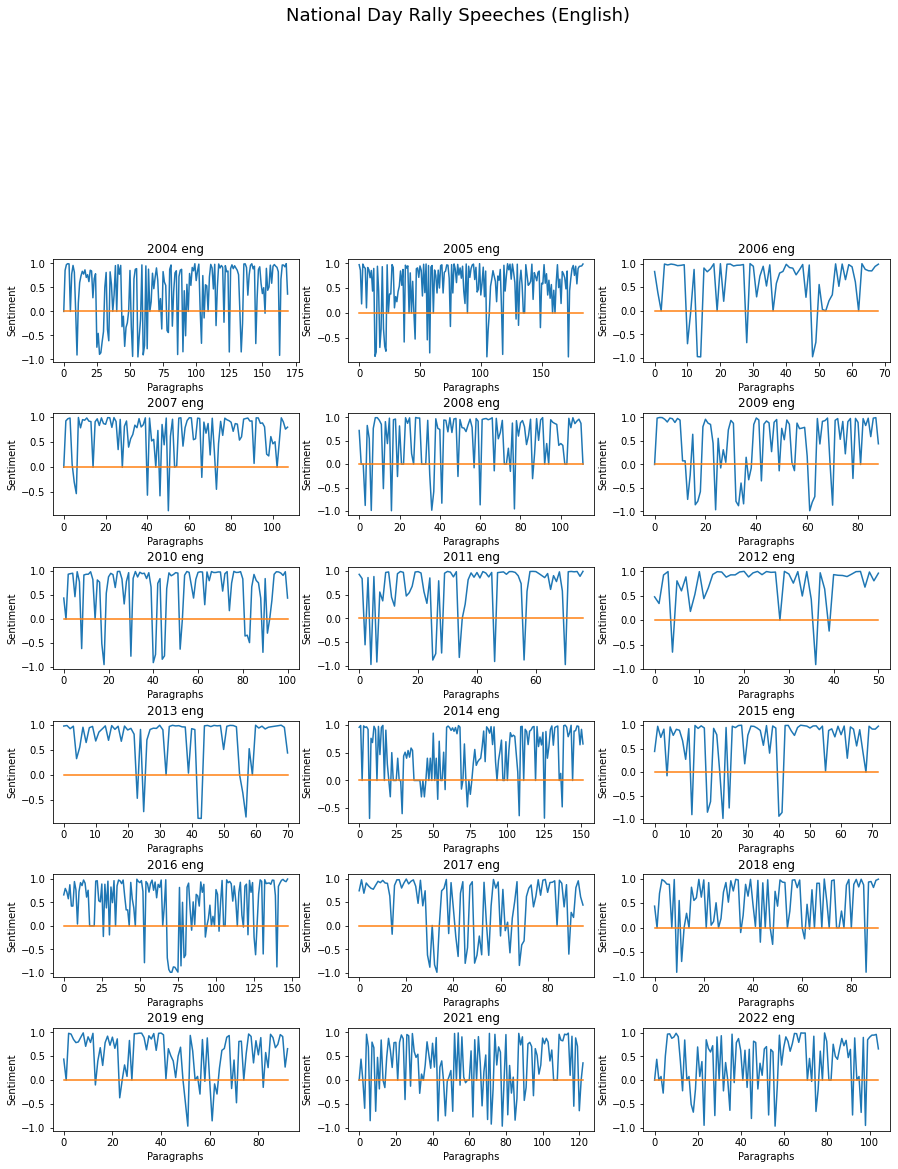

In [11]:
plt.figure(figsize=(15, 50))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("National Day Rally Speeches (English)", fontsize=18, y=0.95)

years = [year[0:4] for year in fids]

# loop through the length of tickers and keep track of index
j = 0
for n, year in enumerate(fids):
    # add a new subplot iteratively
    ax = plt.subplot(18, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    ax.plot(df[df['Year'] == year].ParasNo,df[df['Year'] == year]["Sentiment Score"])
    plt.plot(np.arange(0,len(df[df['Year'] == year])), np.zeros(len(df[df['Year'] == year]))) # add a neutral line

    # chart formatting
    ax.set_title(year[0:4] + " " + year[5:8])
    ax.set_ylabel('Sentiment')
    ax.set_xlabel("Paragraphs")
    


#### Two Groups: Less Positive and More Positive

In [12]:
#Export Overall Sentiment Score
df_results = df.groupby(by='Year').mean("Sentiment Score")
df_results.drop(columns="ParasNo", inplace = True)
df_results['Sentiment'] = df_results['Sentiment Score'].apply(lambda c: 'Positive' if c >0 else 'Negative' if c<0 else 'Neutral')

In [37]:
df_results.sort_values(by='Sentiment Score', inplace=True)

length = len(df_results)
length = int(length/2)

df_results_less_positive = df_results[0:length]
df_results_more_positive = df_results[length:]

In [38]:
df_results_less_positive

,Sentiment Score,Sentiment
Year,,
2021_eng.txt,0.301881,Positive
2022_eng.txt,0.385247,Positive
2004_eng.txt,0.413695,Positive
2009_eng.txt,0.424415,Positive
2017_eng.txt,0.443032,Positive
2016_eng.txt,0.473646,Positive
2014_eng.txt,0.484737,Positive
2008_eng.txt,0.513086,Positive
2018_eng.txt,0.517576,Positive


In [39]:
df_results_more_positive

,Sentiment Score,Sentiment
Year,,
2019_eng.txt,0.523796,Positive
2005_eng.txt,0.550905,Positive
2006_eng.txt,0.597435,Positive
2010_eng.txt,0.603267,Positive
2011_eng.txt,0.616586,Positive
2015_eng.txt,0.644675,Positive
2007_eng.txt,0.653756,Positive
2013_eng.txt,0.711611,Positive
2012_eng.txt,0.737910,Positive


#### Analysis into 2021: Lowest score + During a Global Economic Crisis

In [86]:
df_2021 = df[df['Year']=="2021_eng.txt"]
df_2021.reset_index(drop=True, inplace= True)

pd.set_option('display.max_colwidth', None)
df_2021.sort_values('Sentiment Score').head(15)


,Year,ParasNo,Paragraphs,Clean_Text,scores,Sentiment Score,Sentiment
78,2021_eng.txt,78,"But over time, their race relations and politics polarise. Often, the majority group asserts its power and sidelines the minorities. The minorities find themselves with less and less space, and feel no choice but to push back hard. Sometimes, the minorities pursue aggressive identity politics and the majority group feels pressured and threatened, and rallies around hardline chauvinist leaders. It happens to countries much older than Singapore. Either way, the outcome is unhappy, for both majority and minorities. And once a country has gone down that path, it is very difficult to turn back.",but over time their race relations and politics polarise often the majority group asserts its power and sidelines the minorities the minorities find themselves with less and less space and feel no choice but to push back hard sometimes the minorities pursue aggressive identity politics and the majority group feels pressured and threatened and rallies around hardline chauvinist leaders it happens to countries much older than singapore either way the outcome is unhappy for both majority and minorities and once a country has gone down that path it is very difficult to turn back,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'compound': -0.9586}",-0.9586,Negative
72,2021_eng.txt,72,"Race & Religion\nMy third topic tonight is race and religion. During COVID-19, race relations have come under stress. There have been more racist incidents, several of which were widely publicised on social media. One happened just before National Day. Tanjong Pagar Town Council displayed banners to celebrate, featuring Singaporean families of different races. Unfortunately, netizens picked on one banner showing an Indian family, as though there were no other banners of other races. They made very nasty comments, accusing the government of being pro-foreigner and pro-Indian. Actually, the family is Singaporean, and the son, Thiruben, is a national athlete.",race religion my third topic tonight is race and religion during covid race relations have come under stress there have been more racist incidents several of which were widely publicised on social media one happened just before national day tanjong pagar town council displayed banners to celebrate featuring singaporean families of different races unfortunately netizens picked on one banner showing an indian family as though there were no other banners of other races they made very nasty comments accusing the government of being pro foreigner and pro indian actually the family is singaporean and the son thiruben is a national athlete,"{'neg': 0.154, 'neu': 0.814, 'pos': 0.032, 'compound': -0.9161}",-0.9161,Negative
43,2021_eng.txt,43,"“Kejar” – it means to chase, in Malay. This film captures the pressures on delivery workers, chasing the target and earning their daily keep. Under constant stress for reasons beyond their control: bad weather, scary dogs, motorcycle breakdowns, trying their best to hit their daily targets, and not always succeeding.",kejar it means to chase in malay this film captures the pressures on delivery workers chasing the target and earning their daily keep under constant stress for reasons beyond their control bad weather scary dogs motorcycle breakdowns trying their best to hit their daily targets and not always succeeding,"{'neg': 0.234, 'neu': 0.698, 'pos': 0.068, 'compound': -0.8492}",-0.8492,Negative
6,2021_eng.txt,6,"Many of you have gone beyond the call of duty. Like Aisha Abdul Rahman, a passenger service agent at Changi Airport. After passenger flights were sharply cut, Aisha was redeployed as a cargo agent for cold chain logistics. She learnt to operate a forklift, and now handles temperature-sensitive goods, including vaccines. Roslina Toh is a student volunteer. In March last year, when Malaysia closed its borders, many Malaysian workers were stranded here. Roslina marshalled a team of 200 volunt

**Keyword Specific Search**

In [71]:
#Search in columns 'Clean_Text' for keyword
keyword = 'covid'
mask = df_2021['Clean_Text'].str.contains(keyword, na=False)
keyword_df = df_2021[mask]
keyword_mean = df_2021[mask]['Sentiment Score'].mean()

keyword_mean

0.13517083333333332

In [75]:
keyword_df

,Year,ParasNo,Paragraphs,Clean_Text,scores,Sentiment Score,Sentiment
2,2021_eng.txt,2,COVID-19\nMy last National Day Rally was two years ago.,covid my last national day rally was two years ago,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral
3,2021_eng.txt,3,"Since then, COVID-19 has changed our world. Globally, it has taken millions of lives, sickened many more and disrupted countless jobs and businesses. In Singapore, each time it looks like we have beaten the virus, it breaks through in a different place and forces us to tighten up again.",since then covid has changed our world globally it has taken millions of lives sickened many more and disrupted countless jobs and businesses in singapore each time it looks like we have beaten the virus it breaks through in a different place and forces us to tighten up again,"{'neg': 0.117, 'neu': 0.836, 'pos': 0.046, 'compound': -0.5859}",-0.5859,Negative
4,2021_eng.txt,4,But we have done better than many countries. We have kept our people safe and protected our livelihoods. I thank you all for your trust and cooperation. Your discipline and resilience have made all the difference in the fight against COVID-19.,but we have done better than many countries we have kept our people safe and protected our livelihoods i thank you all for your trust and cooperation your discipline and resilience have made all the difference in the fight against covid,"{'neg': 0.059, 'neu': 0.569, 'pos': 0.372, 'compound': 0.9595}",0.9595,Positive
6,2021_eng.txt,6,"Many of you have gone beyond the call of duty. Like Aisha Abdul Rahman, a passenger service agent at Changi Airport. After passenger flights were sharply cut, Aisha was redeployed as a cargo agent for cold chain logistics. She learnt to operate a forklift, and now handles temperature-sensitive goods, including vaccines. Roslina Toh is a student volunteer. In March last year, when Malaysia closed its borders, many Malaysian workers were stranded here. Roslina marshalled a team of 200 volunteers, to organise food and shelter for them. Priyaa Mohena is a senior physiotherapist at Woodlands Health. She has expertise in respiratory problems, lung problems. So she was deployed to look after COVID-19 patients. I met her recently and asked her – how did you feel? Were you afraid? She said. “I was not afraid. I am proud to give back. I am proud to be Singaporean”.",many of you have gone beyond the call of duty like aisha abdul rahman a passenger service agent at changi airport after passenger flights were sharply cut aisha was redeployed as a cargo agent for cold chain logistics she learnt to operate a forklift and now handles temperature sensitive goods including vaccines roslina toh is a student volunteer in march last year when malaysia closed its borders many malaysian workers were stranded here roslina marshalled a team of volunteers to organise food and shelter for them priyaa mohena is a senior physiotherapist at woodlands health she has expertise in respiratory problems lung problems so she was deployed to look after covid patients i met her recently and asked her how did you feel were you afraid she said i was not afraid i am proud to give back i am proud to be singaporean,"{'neg': 0.088, 'neu': 0.894, 'pos': 0.017, 'compound': -0.8445}",-0.8445,Negative
7,2021_eng.txt,7,"There are many more like Aisha, Roslina and Priyaa – contact tracers, swabbers, ambulance drivers, workers running quarantine facilities and vaccination centres. Because of people like them, we held together in the face of COVID-19 and brought the situation under control. Thank you all!",there are many more like aisha roslina and priyaa contact tracers swabbers ambulance drivers workers running quarantine facilities and vaccination centres because of people like them we held together in the face of covid and brought the situation under control thank you all,"{'neg': 0.0, 'neu': 0.832, 'pos': 0.168, 'compound': 0.7956}",0.7956,Positive
9,2021_eng.txt,9,"Now, 8 i

#### Analysis into 2022: 2nd Lowest Score During a Global Economic Crisis

In [76]:
df_2022 = df[df['Year']=="2022_eng.txt"]
df_2022.reset_index(drop=True, inplace= True)

pd.set_option('display.max_colwidth', None)
df_2022.sort_values('Sentiment Score').head(5)

,Year,ParasNo,Paragraphs,Clean_Text,scores,Sentiment Score,Sentiment
56,2022_eng.txt,56,"What we seek is a political accommodation, one that balances different legitimate views and aspirations among Singaporeans. For some, this will be too modest a step. For others, it will be a step taken only with great reluctance, even regret. But in a society where diverse groups have strongly held opposing views, everyone has to accept that no group can have things all their way. If one side pushes too hard, the other side will push back even harder. In some Western societies, not few, this has resulted in culture wars, contempt for opposing views – not just for their views but for the opposing people, cancel culture to brow beat and shut up opponents, and bitter feuds splitting society into warring tribes. There are some signs of similar things starting to happen here too. I say, let us not go in this direction. All groups should exercise restraint, because that is the only way we can move forward as one nation together.",what we seek is a political accommodation one that balances different legitimate views and aspirations among singaporeans for some this will be too modest a step for others it will be a step taken only with great reluctance even regret but in a society where diverse groups have strongly held opposing views everyone has to accept that no group can have things all their way if one side pushes too hard the other side will push back even harder in some western societies not few this has resulted in culture wars contempt for opposing views not just for their views but for the opposing people cancel culture to brow beat and shut up opponents and bitter feuds splitting society into warring tribes there are some signs of similar things starting to happen here too i say let us not go in this direction all groups should exercise restraint because that is the only way we can move forward as one nation together,"{'neg': 0.17, 'neu': 0.783, 'pos': 0.047, 'compound': -0.9707}",-0.9707,Negative
98,2022_eng.txt,98,"In particular, good leadership is non-negotiable. Look at the countries where governments are unstable and politics messy, swinging wildly from one election to another. Whenever things do not work, leaders are forced out, or resign en-masse. But even after changing teams, things fail to improve. Policies and laws either never make it through the political gridlock or they are made by one government and then reversed by the next. Often, it is not just the leaders who disappoint, but the whole system that has failed. The result is a devastating loss of faith: not just in individual politicians or parties, but in the whole political system and the whole political class, and there is no way forward from there.",in particular good leadership is non negotiable look at the countries where governments are unstable and politics messy swinging wildly from one election to another whenever things do not work leaders are forced out or resign en masse but even after changing teams things fail to improve policies and laws either never make it through the political gridlock or they are made by one government and then reversed by the next often it is not just the leaders who disappoint but the whole system that has failed the result is a devastating loss of faith not just in individual politicians or parties but in the whole political system and the whole political class and there is no way forward from there,"{'neg': 0.21, 'neu': 0.703, 'pos': 0.087, 'compound': -0.9559}",-0.9559,Negative
23,2022_eng.txt,23,"Top of everyone’s minds is the cost of living. Even before the war, inflation was already becoming a problem because COVID-19 had disrupted supply chains and it had also caused developed countries, especially the US, to implement huge spending packages, stoking inflation which spread internationally. But the war has made things worse. Oil and gas supplies from Russia are getting disrupted. This is pushing up energy prices worldwide. Tha